# 作业3：深度学习框架实践

本次作业将练习深度学习框架的使用，大部分内容用 PyTorch 实现。第1题利用卷积层和全连接层实现手写数字的识别，第2题利用 RNN 来实现英文名的自动生成，第3题是算法题，利用卷积运算实现任意大整数的乘法。

### 第1题

1. 目标：通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

2. 主要步骤：获取数据，创建模型结构，定义损失函数，编写训练循环，实施预测。

3. 获取数据。我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
np.random.seed(123)
torch.manual_seed(123)

mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10000, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable

9913344it [00:26, 369718.69it/s]                             
Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

29696it [00:00, 141774.56it/s]                          
Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

1649664it [00:04, 356742.55it/s]                             
Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

5120it [00:00, 1283152.28it/s]          Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Processing...
Done!

D:\Software\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This mea

我们一次性取出随机抽取到的10000个观测，其中 x 是图片数据，y 是图片对应的数字。

In [3]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [4]:
print(x.shape)
print(y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


我们可以利用下面的函数展示图片的内容。如选择第一张图片，先将其转换成 Numpy 数组，再绘制图形：

In [5]:
import matplotlib.pyplot as plt

img = x[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

(28, 28)


<Figure size 640x480 with 1 Axes>

接下来请你选择5个你喜欢的数字（10000以下），然后取出对应位置的图片，并画出它们的内容。

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


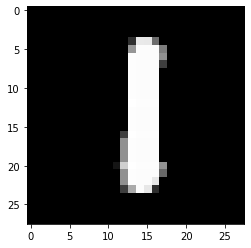

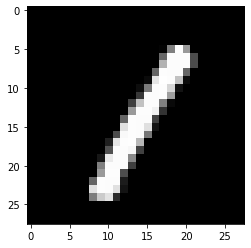

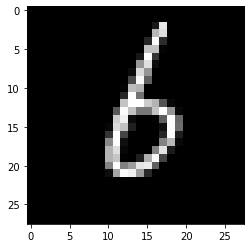

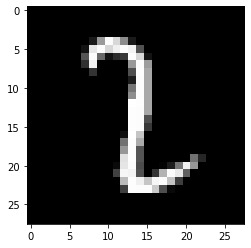

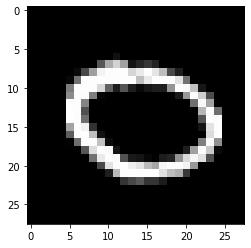

In [6]:
img1 = x[23].squeeze().cpu().numpy()
img2 = x[4567].squeeze().cpu().numpy()
img3 = x[7637].squeeze().cpu().numpy()
img4 = x[7436].squeeze().cpu().numpy()
img5 = x[293].squeeze().cpu().numpy()

print(img1.shape)
print(img2.shape)
print(img3.shape)
print(img4.shape)
print(img5.shape)
plt.imshow(img1, cmap="gray")
plt.show()
plt.imshow(img2, cmap="gray")
plt.show()
plt.imshow(img3, cmap="gray")
plt.show()
plt.imshow(img4, cmap="gray")
plt.show()
plt.imshow(img5, cmap="gray")
plt.show()

4. 搭建模型。我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层（池化层）和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前10个观测，此时输入的维度是 `[10, 1, 28, 28]`：

In [7]:
smallx = x[0:10]
smally = y[0:10]
print(smallx.shape)
print(smally.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [8]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res = conv1(smallx)
print(res.shape)

torch.Size([10, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[10, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

In [9]:
pool1 = torch.nn.Conv2d(in_channels=20, out_channels=20, kernel_size=2, stride=2)
res = pool1(res)
print(res.shape)
conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
res = conv2(res)
print(res.shape)
pool2 = torch.nn.Conv2d(in_channels=50, out_channels=50, kernel_size=2, stride=2)
res = pool2(res)
print(res.shape)
fc1 = torch.nn.Linear(in_features=50*4*4, out_features=500)
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)
res = torch.relu(res)
fc2 = torch.nn.Linear(in_features=500, out_features=10)
res = fc2(res)
print(res.shape)



torch.Size([10, 20, 12, 12])
torch.Size([10, 50, 8, 8])
torch.Size([10, 50, 4, 4])
torch.Size([10, 500])
torch.Size([10, 10])


5. 创建模型类。在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

In [10]:

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = torch.nn.Conv2d(in_channels=20, out_channels=20, kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.pool2 = torch.nn.Conv2d(in_channels=50, out_channels=50, kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=50*4*4, out_features=500)
        self.fc2 = torch.nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.fc1(x.view(-1, 50 * 4 * 4))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x)
        return x


再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[10, 10]`，且输出结果为0到1之间的概率值。

In [11]:
np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
pred = model(smallx)
print(pred.shape)
print(pred)

torch.Size([10, 10])
tensor([[0.1006, 0.1027, 0.0971, 0.0991, 0.1028, 0.1008, 0.0989, 0.0961, 0.1033,
         0.0988],
        [0.1004, 0.1034, 0.0970, 0.0994, 0.1028, 0.1005, 0.0986, 0.0966, 0.1035,
         0.0979],
        [0.1007, 0.1028, 0.0971, 0.0989, 0.1028, 0.0999, 0.0988, 0.0963, 0.1039,
         0.0987],
        [0.1002, 0.1026, 0.0973, 0.0987, 0.1025, 0.1001, 0.0983, 0.0971, 0.1049,
         0.0983],
        [0.1002, 0.1019, 0.0963, 0.0988, 0.1035, 0.0996, 0.0994, 0.0967, 0.1037,
         0.1001],
        [0.1002, 0.1024, 0.0967, 0.0994, 0.1032, 0.1003, 0.0991, 0.0968, 0.1035,
         0.0984],
        [0.1001, 0.1027, 0.0964, 0.0992, 0.1031, 0.1005, 0.0993, 0.0966, 0.1038,
         0.0983],
        [0.1005, 0.1019, 0.0966, 0.0985, 0.1035, 0.1003, 0.0994, 0.0968, 0.1032,
         0.0994],
        [0.0999, 0.1031, 0.0971, 0.0987, 0.1028, 0.1003, 0.0990, 0.0960, 0.1040,
         0.0992],
        [0.0999, 0.1032, 0.0971, 0.0988, 0.1035, 0.1004, 0.0988, 0.0962, 0.1039,
       

`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [12]:
print(model)

MyModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): Conv2d(20, 20, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): Conv2d(50, 50, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


6. 损失函数。对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [13]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)


tensor(2.3020, grad_fn=<NllLossBackward>)

7. 利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。

In [14]:
model = MyModel()
nepoch = 10
learning_rate = 0.001
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(nepoch):
    loader = DataLoader(mnist, batch_size=200, shuffle=True)
    x, y = next(iter(loader))
    pred = model(x)

    loss = lossfn(torch.log(pred), y)

    print(f"iteration {i}, loss = {loss.item()}, prediction = {pred.detach().numpy().squeeze()}")

    opt.zero_grad()
    loss.backward()
    opt.step()


iteration 0, loss = 2.2994019985198975, prediction = [[0.09606562 0.10630714 0.09571653 ... 0.10163944 0.09815796 0.10326614]
 [0.0962467  0.10638786 0.09611835 ... 0.10159162 0.09826134 0.10295098]
 [0.09611351 0.1067588  0.09546079 ... 0.10192002 0.09803085 0.10318559]
 ...
 [0.09677649 0.10644003 0.0958413  ... 0.10143472 0.09799951 0.10349455]
 [0.09661138 0.10684768 0.09548227 ... 0.10244971 0.09771762 0.10248787]
 [0.09644525 0.10621992 0.09556885 ... 0.10162458 0.09822908 0.10325385]]
D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
iteration 1, loss = 2.2941036224365234, prediction = [[0.09497759 0.11118372 0.09164773 ... 0.10899805 0.08800758 0.10401649]
 [0.09512907 0.11221647 0.09112655 ... 0.10765148 0.08902364 0.10306831]
 [0.09648997 0.11178397 0.0911095  ... 0.1096554  0.0885753  0.10394223]
 ...
 [0.09571832 0.11258111 0.09144631 ... 

为了验证模型的效果，我们对前10个观测（即之前生成的 `smallx` 和 `smally`）进行预测。

In [15]:
ypred = model(smallx)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(smally)

[[0.084 0.03  0.026 0.032 0.059 0.036 0.032 0.558 0.027 0.115]
 [0.041 0.018 0.052 0.02  0.318 0.035 0.112 0.158 0.034 0.213]
 [0.219 0.037 0.026 0.179 0.07  0.217 0.089 0.035 0.058 0.071]
 [0.062 0.069 0.059 0.076 0.252 0.071 0.191 0.039 0.043 0.137]
 [0.733 0.01  0.013 0.041 0.015 0.087 0.025 0.038 0.02  0.018]
 [0.063 0.091 0.059 0.034 0.1   0.055 0.053 0.316 0.06  0.169]
 [0.02  0.377 0.158 0.066 0.072 0.031 0.03  0.06  0.134 0.051]
 [0.785 0.006 0.019 0.021 0.013 0.047 0.051 0.032 0.012 0.014]
 [0.071 0.055 0.043 0.075 0.075 0.059 0.032 0.381 0.055 0.153]
 [0.035 0.043 0.041 0.07  0.287 0.065 0.063 0.1   0.068 0.227]]
tensor([7, 4, 5, 4, 0, 7, 1, 0, 7, 4])
D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

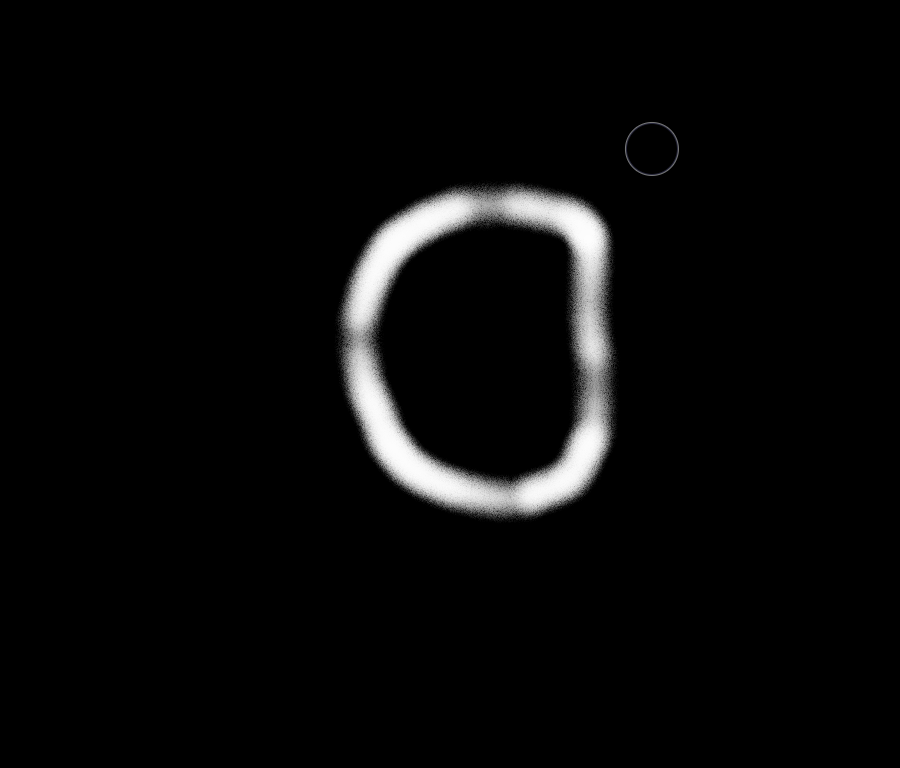

In [16]:
from PIL import Image
im = Image.open("digits/0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [17]:
im_arr = np.array(im)
print(im_arr.shape)

(768, 900, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [18]:
im = im.convert("L")
im = im.resize((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [19]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [20]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.086 0.114 0.08  0.071 0.117 0.085 0.104 0.133 0.076 0.135]]
D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

In [21]:
for i in range(10):
    im = Image.open("digits/%i.png"%i)
    im = im.convert("L")
    im = im.resize((28, 28))
    im_arr = np.array(im)

    test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)

    pred0 = model(test0)
    print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.086 0.114 0.08  0.071 0.117 0.085 0.104 0.133 0.076 0.135]]
[[0.073 0.198 0.08  0.076 0.094 0.088 0.091 0.102 0.094 0.104]]
[[0.051 0.217 0.08  0.084 0.112 0.082 0.081 0.077 0.104 0.112]]
[[0.088 0.134 0.076 0.146 0.086 0.095 0.071 0.109 0.098 0.098]]
[[0.058 0.148 0.085 0.072 0.139 0.079 0.146 0.081 0.074 0.118]]
[[0.112 0.138 0.069 0.092 0.082 0.11  0.109 0.107 0.084 0.099]]
[[0.063 0.161 0.079 0.107 0.109 0.09  0.124 0.074 0.092 0.102]]
[[0.09  0.134 0.076 0.087 0.085 0.075 0.062 0.193 0.078 0.12 ]]
[[0.065 0.248 0.079 0.081 0.079 0.083 0.092 0.088 0.096 0.089]]
[[0.082 0.239 0.065 0.099 0.074 0.086 0.067 0.119 0.085 0.085]]
D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### 第2题

1. 目标：通过对英文名数据进行训练，构建一个 RNN 模型，实现英文名的自动生成。

2. 主要步骤：获取和整理数据，对字符串进行 one-hot 编码，创建模型结构，定义损失函数，编写训练循环，最后生成人名字符串。

3. 获取和整理数据。数据文件已存为 `data/names.txt`，先将其读取为字符串列表：

In [22]:
import io
lines = io.open("data/names.txt").read().strip().split('\n')
print(len(lines))
print(lines[0:5])

3668
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


可以看出，共读取了3668个名字。为了简单起见，我们将所有的大写字母转换为小写。

In [23]:
names = [s.lower() for s in lines]
print(names[0:5])

['abbas', 'abbey', 'abbott', 'abdi', 'abel']


接下来我们需要构建一个字符的字典。对于英文名来说很简单，即26个字母。我们可以通过下面的代码直接得到。

In [24]:
import string
dict = string.ascii_lowercase
dict

'abcdefghijklmnopqrstuvwxyz'

4. 下面准备好 one-hot 编码所需的函数。编写函数 `char2index(char)`，将一个字母转换为其所在字典的位置。例如 `char2index("a")` 要返回0，`char2index("z")` 要返回25，等等。提示：使用字符串的 `.find()` 函数。

In [25]:
def char2index(char):
    dict = string.ascii_lowercase
    return dict.find(char)

print(char2index("z") == 25)

True


编写 `char2tensor(char)` 函数，将一个字母转换为 one-hot 向量，即该向量中第 i 个元素为1，其余为0，其中 i 表示该字母在字典中的位置。

**注意，该向量的长度应为27，因为我们要预留终止符，用 `[0.0, 0.0, ..., 1.0]` 表示**。

`char2tensor("a")` 应返回 `torch.tensor([1.0, 0.0, ...])`，`char2tensor("z")` 应返回 `torch.tensor([0.0, ..., 1.0, 0.0])`。

In [26]:
def char2tensor(char):
    out = torch.zeros(27)
    out[char2index(char)] = 1.0
    return out

print(char2tensor("a"))
print(char2tensor("z"))
print(char2tensor("z").shape[0] == 27)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])
True


5. 构建模型。我们使用最简单的 RNN 结构，即隐藏单元是输入和上一期隐藏单元的线性变换加上 Tanh 激活函数，输出单元是隐藏单元的线性变换加上 Softmax 激活函数。输出的结果代表下一个字符的概率分布。

In [27]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(in_features=input_size+hidden_size, out_features=hidden_size)
        self.h2o = torch.nn.Linear(in_features=hidden_size, out_features=input_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


我们做一个简单的测试。请在下面的代码中加入适当的语句，使得每次运行的结果不变。根据其输出结果，请问当前模型预测字符a的下一个字符是什么？为什么？

In [28]:
np.random.seed(123)
torch.manual_seed(123)


rnn = RNN(input_size=27, hidden_size=10)
input = char2tensor("a")
hidden = rnn.init_hidden()
output, hidden = rnn(input.view(1, 27), hidden)
print(output)

tensor([[0.0290, 0.0327, 0.0320, 0.0354, 0.0432, 0.0395, 0.0417, 0.0371, 0.0409,
         0.0275, 0.0328, 0.0359, 0.0373, 0.0391, 0.0339, 0.0366, 0.0430, 0.0364,
         0.0472, 0.0435, 0.0376, 0.0327, 0.0418, 0.0370, 0.0279, 0.0426, 0.0357]],
       grad_fn=<SoftmaxBackward>)


6. 接下来我们定义好损失函数。与第1题中类似，预测值是一个概率分布，而真实的标签是0到26中的一个整数，代表真实的下一个字符在字典中的位置。假设当前处理的名字为"abel"，那么字符a的输出结果对应的标签是什么？请完成下面的代码。

In [29]:
# Change "target" to a proper value
target = 1
lossfn = torch.nn.NLLLoss()
loss = lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(3.4199, grad_fn=<NllLossBackward>)


7. 明确单个字符的损失函数的计算方法后，请在下面计算出"abel"这个观测整体的损失函数值。

In [30]:
name = 'abel'
nchar = len(name)
for j in range(nchar):
    input = char2tensor(name[j])
    output, hidden = rnn(input.view(1,27), hidden)

    if j == nchar - 1:
        target = 26
    else:
        target = char2index(name[j + 1])
    loss = loss + lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(16.5950, grad_fn=<AddBackward0>)


8. 将上述过程在数据上进行反复迭代，训练模型。

In [31]:
np.random.seed(123)
torch.random.manual_seed(123)

n = len(names)
n_hidden = 16
n_input = 27
nepoch = 10

rnn = RNN(n_input, n_hidden)
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
train_ind = np.arange(n)
losses = []

lossfn = torch.nn.NLLLoss()

# Loop over epochs
for k in range(nepoch):
    # Shuffle the data
    np.random.shuffle(train_ind)
    # Loop over observations. Each observation is a name
    for i in range(n):
        name = names[train_ind[i]]
        nchar = len(name)
        # Loop over the characters in the name
        # Each input character has a target, which is the index of the next character in the dictionary
        # For the last character in the name, the target is the end-of-sequence symbol, which has index 26
        loss = 0.0
        hidden = rnn.init_hidden()
        for j in range(nchar):
            input = char2tensor(name[j])
            output, hidden = rnn(input.view(1, n_input), hidden)

            if j == nchar - 1:
                target = 26
            else:
                target = char2index(name[j + 1])

            loss = loss + lossfn(torch.log(output), torch.tensor([target]))
    
        loss = loss / nchar

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"epoch {k}, obs {i}, loss = {loss.item()}")

epoch 0, obs 0, loss = 3.3991856575012207
epoch 0, obs 1000, loss = 2.918344020843506
epoch 0, obs 2000, loss = 2.6398532390594482
epoch 0, obs 3000, loss = 3.1096529960632324
epoch 1, obs 0, loss = 2.776276111602783
epoch 1, obs 1000, loss = 2.5617995262145996
epoch 1, obs 2000, loss = 2.415987014770508
epoch 1, obs 3000, loss = 2.4527029991149902
epoch 2, obs 0, loss = 2.5975751876831055
epoch 2, obs 1000, loss = 2.585355520248413
epoch 2, obs 2000, loss = 2.5821340084075928
epoch 2, obs 3000, loss = 2.7673685550689697
epoch 3, obs 0, loss = 2.584155559539795
epoch 3, obs 1000, loss = 2.1915831565856934
epoch 3, obs 2000, loss = 2.4389891624450684
epoch 3, obs 3000, loss = 2.0150928497314453
epoch 4, obs 0, loss = 2.4576306343078613
epoch 4, obs 1000, loss = 2.9122250080108643
epoch 4, obs 2000, loss = 2.5470449924468994
epoch 4, obs 3000, loss = 2.1251466274261475
epoch 5, obs 0, loss = 2.283302068710327
epoch 5, obs 1000, loss = 2.564319133758545
epoch 5, obs 2000, loss = 2.1136810

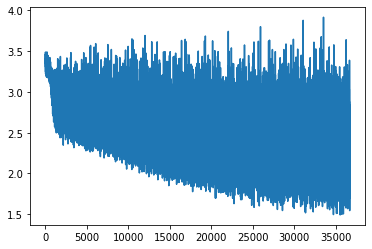

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)

9. 编写一个函数 `random_first_letter()`，它随机返回字典中的一个字符，我们将利用它来随机生成第一个字符。

In [33]:
import random
def random_first_letter():
    dict = string.ascii_lowercase
    a = random.choice(dict)
    return a

print(random_first_letter())
print(random_first_letter())
print(random_first_letter())

h
d
v


请简要说明如下的代码的含义（可以在代码中加入注释），然后利用它随机生成10个名字。评价生成的结果，并简要说明可以如何改进模型的效果？

In [34]:
def random_name(max_len=20):
    rnn.eval()
    first_letter = random_first_letter()
    char_ind = [char2index(first_letter)]
    input = char2tensor(first_letter)
    hidden = rnn.init_hidden()
    for i in range(max_len - 1):
        output, hidden = rnn(input.view(1, n_input), hidden)
        ind = torch.argmax(output).item()
        if ind == 26:
            break
        char_ind.append(ind)
        input.zero_()
        input[ind] = 1.0
    return "".join([dict[i] for i in char_ind])

random_name函数主要步骤是首先随机生成一个首字母然后将其转化为one-hot向量输入rnn模型，然后执行循环，
根据上一个字母预测下一个字母，若预测结果为终止符号则结束循环，返回预测结果。

In [35]:
for i in range(10):
    print(random_name())

yar
garlen
jarlen
tone
warlen
arer
zarlen
harlen
tone
darlen


### 第3题

利用卷积函数实现任意大整数的乘法。给定两个整数，如 183612 和 23333，用两个列表表达它们的序列：

In [36]:
n1 = [1, 8, 3, 6, 1, 2]
n2 = [2, 3, 3, 3, 3]

请编写一个函数 `integer_mult(n1, n2)`，返回 `n1 * n2` 对应的整数序列。注意不要直接调用乘法表达式（设想有两个非常大的整数，直接相乘可能会导致数值溢出）。

In [37]:
def integer_mult(n1, n2):
    # Implementation here
    n1.reverse()
    n2.reverse()

    ans1 = [0 for i in range(len(n1)+len(n2)-1)]
    for i in range(len(n1)):
        for j in range(len(n2)):
            ans1[i+j] += n1[i]*n2[j]
    for i in range(len(ans1)-1):
        if ans1[i] >= 10:
            ans1[i+1] += ans1[i]//10
            ans1[i] = ans1[i]%10

    last = ans1[len(ans1)-1]
    if last >= 10:
        ans1.append(last//10)
        ans1[len(ans1)-2] = last%10
    return ans1

res = integer_mult(n1, n2)
res.reverse()
print(res == [4, 2, 8, 4, 2, 1, 8, 7, 9, 6])

True


思路：

1. 先实现多项式的乘法。例如，给定 $p(x)=1+2x+x^4$ 和 $q(x)=x+3x^2+5x^3$，计算 $r(x)=p(x)q(x)$。我们将 $p(x)$ 编码为 `p = [1, 2, 0, 0, 1]`，$q(x)$ 编码为 `q = [0, 1, 3, 5]`，请编写函数 `poly_mult(p, q)`，使得 `poly_mult(p, q) == [0, 1, 5, 11, 10, 1, 3, 5]`。

In [38]:
p = [1, 2, 0, 0, 1]
q = [0, 1, 3, 5]


def poly_mult(p, q):
    # Implementation here
    ans = [0 for i in range(len(p)+len(q)-1)]
    for i in range(len(p)):
        for j in range(len(q)):
            ans[i+j] += p[i]*q[j]
    return ans

print(poly_mult(p, q) == [0, 1, 5, 11, 10,  1, 3, 5])

True


2. 对于任意的一个整数，将其看成是某个多项式在 $x=10$ 处的取值，如 $123 = p_1(10)$，$p_1(x)=3+2x+x^2$，$5310 = p_2(10)$，$p_2(x)=x+3x^2+5x^3$，注意需要适当将序列反序。因此，要计算 $123\times 5310$，相当于计算 $r(10)$ 的值，但为了避免直接进行乘法运算（防止溢出），可以先计算 $r(x)$ 的表达式（等价于其系数向量），然后建立起 $r(x)$ 的系数与 $r(10)$ 之间的联系（见如下第3点）。

3. 如果一个多项式 $r(x)$ 所有的系数都是0到9之间的整数，那么 $r(x)$ 和 $r(10)$ 的关系非常直接，比如若 $r(x)=1+2x+5x^2+3x^3$，则 $r(10)=3521$。但如果有系数超过10，就需要考虑进位的影响，比如 $r(x)=1+11x+2x^2$，$r(10)=311$。此时可以从 $r(x)$ 的第一项开始逐项进位，构造一个新的多项式 $r'(x)=1+x+3x^2$，满足 $r'(10)=r(10)$，且 $r'(x)$ 所有的系数都不超过10。

4. 综合利用以上信息，完成本题的算法编写。并测试 23742389754298365 * 809723950 的结果。

In [39]:
p = [5,6,3,8,9,2,4,5,7,9,8,3,2,4,7,3,2]
q = [0,5,9,3,2,7,9,0,8]
ans1 = poly_mult(p,q)
for i in range(len(ans1)-1):
    if ans1[i] >= 10:
        ans1[i+1] += ans1[i]//10
        ans1[i] = ans1[i]%10

last = ans1[len(ans1)-1]
if last >= 10:
    ans1.append(last//10)
    ans1[len(ans1)-2] = last%10
print(ans1)



[0, 5, 7, 1, 4, 3, 6, 8, 5, 1, 0, 0, 0, 9, 2, 4, 1, 6, 1, 8, 7, 4, 2, 2, 9, 1]
